In [1]:
import sys
import time
import datetime
from qudi.util.network import netobtain
import matplotlib.pyplot as plt
import importlib
sys.path.append('../xq1i')
import libxq1i
importlib.reload(libxq1i)

confocal2 = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

go to POI POI_1 ...
... position and counts at peak after refocus: (7.258, 51.876, -8.444) µm,  σ= (0.154, 0.390, 0.600) µm, peak cnts: 9.79E+04
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/5000000.0 [00:00<?, ?sweeps/s]

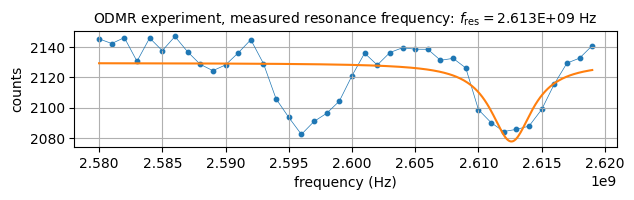

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/5000000.0 [00:00<?, ?sweeps/s]

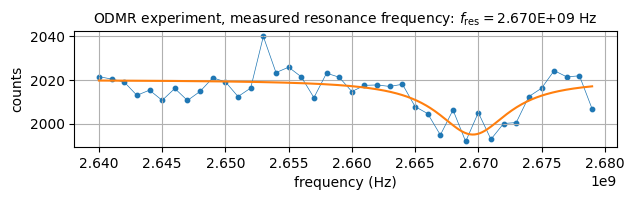

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/5000000.0 [00:00<?, ?sweeps/s]

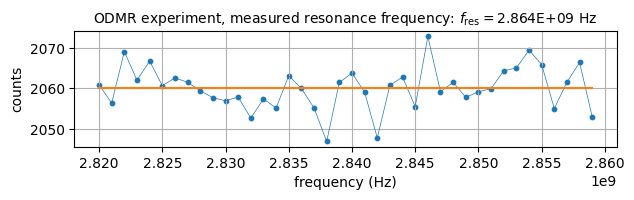

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/5000000.0 [00:00<?, ?sweeps/s]

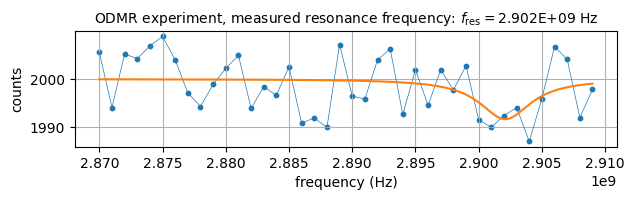

... all POIs in the list measured


In [2]:
outputFilename = f"characterization_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.txt"
outputFile = open(outputFilename, 'w')

orientation_properties = {
    1: {'res_freq': 2.605e9, 'freq_range': [2.580e9, 1.0e6, 40],  'rabi_period': 2.73e-7},
    2: {'res_freq': 2.665e9, 'freq_range': [2.640e9, 1.0e6, 40],  'rabi_period': 5.06e-7},
    3: {'res_freq': 2.840e9, 'freq_range': [2.820e9, 1.0e6, 40],  'rabi_period': 2.93e-7},
    4: {'res_freq': 2.887e9, 'freq_range': [2.870e9, 1.0e6, 40],  'rabi_period': 2.05e-7},
    5: {'res_freq': 2.900e9, 'freq_range': [2.550e9, 2.5e6, 300], 'rabi_period': 2.05e-7},
}

poi_list = [
    {'poi': 'POI_1', 'orientations': [1,2,3,4]},
]


pulsed_master_logic.clear_pulse_generator()
time.sleep(1)

for entry in poi_list:
    currPoi = entry['poi']
    print(f'go to POI {currPoi} ...')
    # disable tracking before moving to the next POI
    poi_manager_logic.toggle_periodic_refocus(False)
    # wait until an ongoing optimization is terminated
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    # move to next POI
    poi_manager_logic.go_to_poi(currPoi)
    poi_manager_logic.set_active_poi(currPoi)
    # enable tracking of POI
    poi_manager_logic.toggle_periodic_refocus(True)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    print( '... position and counts at peak after refocus: ' + scanner_gui.optimizer_dockwidget.result_label.text() )

    for orientation in entry['orientations']:
        print(f'start measurements for orientation {orientation} ...')
        countsStart = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]
        
        # pulsed ODMR
        confocal2.pulsedODMR_params['freq_start'] = orientation_properties[orientation]['freq_range'][0]
        confocal2.pulsedODMR_params['freq_step'] = orientation_properties[orientation]['freq_range'][1]
        confocal2.pulsedODMR_params['num_of_points'] = orientation_properties[orientation]['freq_range'][2]
        #confocal2.generate_params['rabi_period'] = rabi_period
        confocal2.generate_params['rabi_period'] = orientation_properties[orientation]['rabi_period']
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.pulsedODMR_sweeps = 5e6
        #confocal2.pulsedODMR_sweeps = 2e6
        confocal2.do_pulsedODMR( f'{currPoi}_ornt_{orientation}')
        result_dict = netobtain( pulsed_measurement_logic.do_fit('Lorentzian Dip') )
        res_freq = result_dict.params['center'].value
        confocal2.generate_params['microwave_frequency'] = res_freq
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        fData = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData = netobtain(pulsed_measurement_logic.signal_data[1])
        plt.figure(figsize=(7, 1.5))
        plt.plot(fData, sigData, linewidth=0.5)
        plt.scatter(fData, sigData, s=10)
        plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
        plt.grid()
        plt.title(rf'ODMR experiment, measured resonance frequency: $f_\mathrm{{res}} =${res_freq:.3E} Hz', fontsize=10)
        plt.ylabel('counts')
        plt.xlabel(r'frequency (Hz)')
        plt.show()

        
        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsEnd = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        #outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\t{rabi_period:.2E}\t{t2:.2E}\t{t2star:.2E}\n" )
        #outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\t{rabi_period:.2E}\t{t2:.2E}\t{t2_dd:.2E}\t{t2star:.2E}\n" )
        outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\n" )
        outputFile.flush()

print('... all POIs in the list measured')
outputFile.close()

In [ ]:
import os
os.getcwd()